In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import models
import matplotlib.pyplot as plt

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

In [3]:
# Load and preprocess the WM811K dataset
def load_wm811k_data(path_to_dataset):
    # Load dataset and perform preprocessing based on provided script
    df = pd.read_pickle(path_to_dataset)
    df = df.drop(['waferIndex'], axis=1)  # Drop unnecessary columns
    df['waferMapDim'] = df['waferMap'].apply(lambda x: (np.size(x, axis=0), np.size(x, axis=1)))
    df['failureNum'] = df['failureType']
    mapping_type = {'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3, 'Loc': 4, 'Random': 5, 'Scratch': 6, 'Near-full': 7, 'none': 8}
    df = df.replace({'failureNum': mapping_type})

    # Segregate into with pattern wafers only
    df_withpattern = df[(df['failureNum'] >= 0) & (df['failureNum'] <= 7)].reset_index()

    wafer_maps = df_withpattern['waferMap'].to_numpy()
    labels = df_withpattern['failureNum'].to_numpy()

    # Resize images to (32, 32) and normalize
    data = []
    for wafer_map in wafer_maps:
        resized = np.array(wafer_map, dtype=np.float32)
        if resized.shape[0] != 32 or resized.shape[1] != 32:
            resized = np.resize(resized, (32, 32))
        data.append(resized)

    data = np.expand_dims(data, axis=1)  # Adding channel dimension
    data = np.array(data)

    return data, labels


In [4]:
#load_wm811k_data("C:/Users/Soumya Taneja/Desktop/Sideproject/WM811Kdata/LSWMD.pkl")


In [5]:
# Custom Dataset class for WM811K wafer map dataset
def create_wafer_dataset(data, labels, transform=None):
    return [(transform(image) if transform else image, label) for image, label in zip(data, labels)]

# Split data into training and test sets
data, labels = load_wm811k_data("C:/Users/Soumya Taneja/Desktop/Sideproject/WM811Kdata/LSWMD.pkl")
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create Dataset objects
train_dataset = create_wafer_dataset(train_data, train_labels, transform=transform)
test_dataset = create_wafer_dataset(test_data, test_labels, transform=transform)

# DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Define the feature generator (VGG16) and classifiers
feature_generator = models.vgg16(pretrained=False)  # VGG16 without pretrained weights
feature_generator.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # Adjusting input channel
feature_generator.classifier[6] = nn.Linear(4096, 256)

classifier_main = nn.Linear(256, len(np.unique(labels)))
classifier_aux1 = nn.Linear(256, len(np.unique(labels)))
classifier_aux2 = nn.Linear(256, len(np.unique(labels)))

# Model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_generator = feature_generator.to(device)
classifier_main = classifier_main.to(device)
classifier_aux1 = classifier_aux1.to(device)
classifier_aux2 = classifier_aux2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(feature_generator.parameters()) + list(classifier_main.parameters()) +
                       list(classifier_aux1.parameters()) + list(classifier_aux2.parameters()),
                       lr=2e-4, betas=(0.9, 0.999), eps=1e-8)

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    feature_generator.train()
    classifier_main.train()
    classifier_aux1.train()
    classifier_aux2.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Adjust the input shape to match expected input (batch_size, channels, height, width)
        images = images.view(-1, 1, 32, 32)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        features = feature_generator(images)
        outputs_main = classifier_main(features)
        outputs_aux1 = classifier_aux1(features)
        outputs_aux2 = classifier_aux2(features)

        # Loss calculation for main and auxiliary classifiers
        loss_main = criterion(outputs_main, labels)
        loss_aux1 = criterion(outputs_aux1, labels)
        loss_aux2 = criterion(outputs_aux2, labels)
        loss = loss_main + 0.4 * (loss_aux1 + loss_aux2) #Can experiment with differenet values

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()



    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

In [ ]:
# Testing loop
feature_generator.eval()
classifier_main.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, 1, 32, 32)  # Adjust the input shape to match expected input (batch_size, channels, height, width)
        features = feature_generator(images)
        outputs = classifier_main(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

In [ ]:
# Visualize some test results
fig, axes = plt.subplots(1, 10, figsize=(20, 10))
with torch.no_grad():
    for i in range(10):
        img, label = test_dataset[i]
        img_tensor = img.unsqueeze(0).to(device)
        img_tensor = img_tensor.view(1, 1, 32, 32)
        features = feature_generator(img_tensor)
        output = classifier_main(features)
        _, predicted = torch.max(output, 1)

        img = img.squeeze().cpu().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"True: {label}, Pred: {predicted.item()}")
        axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#2nd version
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import models
import matplotlib.pyplot as plt

# Load and preprocess the WM811K dataset
def load_wm811k_data(path_to_dataset):
    # Load dataset and perform preprocessing based on provided script
    df = pd.read_pickle(path_to_dataset)
    df = df.drop(['waferIndex'], axis=1)  # Drop unnecessary columns
    df['waferMapDim'] = df['waferMap'].apply(lambda x: (np.size(x, axis=0), np.size(x, axis=1)))
    df['failureNum'] = df['failureType']
    mapping_type = {'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3, 'Loc': 4, 'Random': 5, 'Scratch': 6, 'Near-full': 7, 'none': 8}
    df = df.replace({'failureNum': mapping_type})

    # Segregate into with pattern wafers only
    df_withpattern = df[(df['failureNum'] >= 0) & (df['failureNum'] <= 7)].reset_index()

    wafer_maps = df_withpattern['waferMap'].to_numpy()
    labels = df_withpattern['failureNum'].to_numpy()

    # Resize images to (32, 32) and normalize
    data = []
    for wafer_map in wafer_maps:
        resized = np.array(wafer_map, dtype=np.float32)
        if resized.shape[0] != 32 or resized.shape[1] != 32:
            resized = np.resize(resized, (32, 32))
        data.append(resized)

    data = np.expand_dims(data, axis=1)  # Adding channel dimension
    data = np.array(data)

    return data, labels

# Custom Dataset class for WM811K wafer map dataset
def create_wafer_dataset(data, labels, transform=None):
    return [(transform(image) if transform else image, label) for image, label in zip(data, labels)]

# Split data into source (labeled) and target (unlabeled) domains
data, labels = load_wm811k_data("C:/Users/Soumya Taneja/Desktop/Sideproject/WM811Kdata/LSWMD.pkl")
train_data_source, train_data_target, train_labels_source, _ = train_test_split(data, labels, test_size=0.5, random_state=42)
train_data, test_data, train_labels, test_labels = train_test_split(train_data_source, train_labels_source, test_size=0.2, random_state=42)

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create Dataset objects
train_dataset = create_wafer_dataset(train_data, train_labels, transform=transform)
test_dataset = create_wafer_dataset(test_data, test_labels, transform=transform)
target_dataset = create_wafer_dataset(train_data_target, [0] * len(train_data_target), transform=transform)  # Target domain without labels

# DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True)

# Define the feature generator (VGG16) and classifiers
feature_generator = models.vgg16(pretrained=False)  # VGG16 without pretrained weights
feature_generator.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # Adjusting input channel
feature_generator.classifier[6] = nn.Linear(4096, 256)

classifier_main = nn.Linear(256, len(np.unique(labels)))
classifier_aux1 = nn.Linear(256, len(np.unique(labels)))
classifier_aux2 = nn.Linear(256, len(np.unique(labels)))

# Model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_generator = feature_generator.to(device)
classifier_main = classifier_main.to(device)
classifier_aux1 = classifier_aux1.to(device)
classifier_aux2 = classifier_aux2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(feature_generator.parameters()) + list(classifier_main.parameters()) +
                       list(classifier_aux1.parameters()) + list(classifier_aux2.parameters()),
                       lr=2e-4, betas=(0.9, 0.999), eps=1e-8)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    feature_generator.train()
    classifier_main.train()
    classifier_aux1.train()
    classifier_aux2.train()
    running_loss = 0.0

    # Train on source domain (labeled data)
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Adjust the input shape to match expected input (batch_size, channels, height, width)
        images = images.view(-1, 1, 32, 32)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        features = feature_generator(images)
        outputs_main = classifier_main(features)
        outputs_aux1 = classifier_aux1(features)
        outputs_aux2 = classifier_aux2(features)

        # Loss calculation for main and auxiliary classifiers
        loss_main = criterion(outputs_main, labels)
        loss_aux1 = criterion(outputs_aux1, labels)
        loss_aux2 = criterion(outputs_aux2, labels)
        loss = loss_main + 0.3 * (loss_aux1 + loss_aux2)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print detailed outputs for every 100 batches
        #if (i + 1) % 100 == 0:
            #print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Train on target domain (unlabeled data) for feature alignment
    for i, (images, _) in enumerate(target_loader):
        images = images.to(device)
        images = images.view(-1, 1, 32, 32)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        features = feature_generator(images)
        outputs_aux1 = classifier_aux1(features)
        outputs_aux2 = classifier_aux2(features)

        # Adversarial loss to align target features with source features
        soft_labels = torch.softmax(outputs_aux1, dim=1)  # Generate pseudo-labels from auxiliary classifier
        loss_aux = criterion(outputs_aux2, soft_labels.argmax(dim=1))
        loss = 0.3 * loss_aux  # Weight the auxiliary loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Testing loop
feature_generator.eval()
classifier_main.eval()
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, 1, 32, 32)  # Adjust the input shape to match expected input (batch_size, channels, height, width)
        features = feature_generator(images)
        outputs = classifier_main(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Visualize some test results
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
with torch.no_grad():
    for i in range(10):
        img, label = test_dataset[i]
        img_tensor = img.unsqueeze(0).to(device)
        img_tensor = img_tensor.view(1, 1, 32, 32)
        features = feature_generator(img_tensor)
        output = classifier_main(features)
        _, predicted = torch.max(output, 1)

        img = img.squeeze().cpu().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"True: {label}, Pred: {predicted.item()}")
        axes[i].axis('off')
plt.tight_layout()
plt.show()


c:\Users\Soumya Taneja\myAnaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Soumya Taneja\myAnaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Source Loss: 2.5061, Target Loss: 0.0071
Epoch [2/50], Source Loss: 3.5530, Target Loss: 0.0059
Epoch [3/50], Source Loss: 3.1645, Target Loss: 0.0076
Epoch [4/50], Source Loss: 3.2052, Target Loss: 0.0027
Epoch [5/50], Source Loss: 2.5831, Target Loss: 0.0069
Epoch [6/50], Source Loss: 2.8499, Target Loss: 0.0053
Epoch [7/50], Source Loss: 4.7034, Target Loss: 0.0088
Epoch [8/50], Source Loss: 3.0919, Target Loss: 0.0081
Epoch [9/50], Source Loss: 2.7636, Target Loss: 0.0042
Epoch [10/50], Source Loss: 2.6702, Target Loss: 0.0047
Epoch [11/50], Source Loss: 2.9670, Target Loss: 0.0069
Epoch [12/50], Source Loss: 2.9634, Target Loss: 0.0060
Epoch [13/50], Source Loss: 5.0783, Target Loss: 0.0081
Epoch [14/50], Source Loss: 2.8851, Target Loss: 0.0134
Epoch [15/50], Source Loss: 8.2109, Target Loss: 0.0081
Epoch [16/50], Source Loss: 4.1226, Target Loss: 0.0053
Epoch [17/50], Source Loss: 2.4289, Target Loss: 0.0156
Epoch [18/50], Source Loss: 3.8798, Target Loss: 0.0143
E

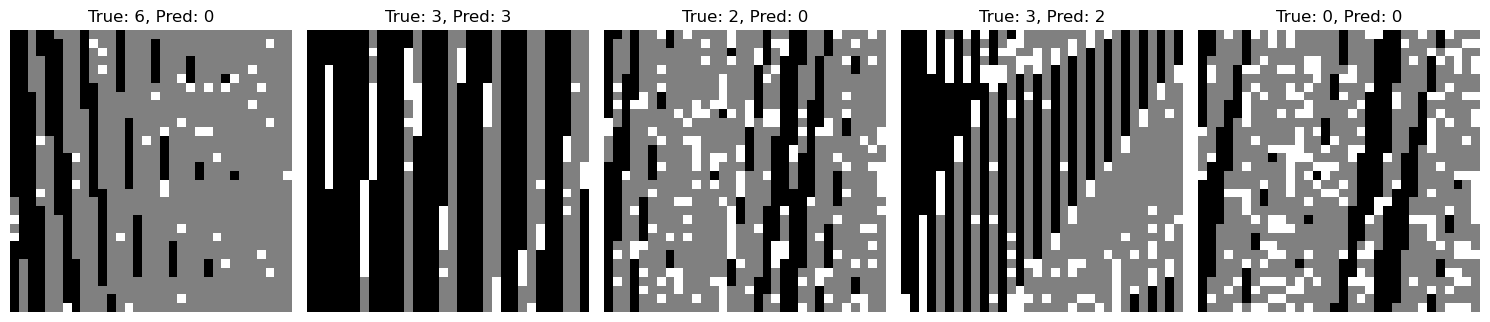

In [1]:
#3rd version
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import models
import matplotlib.pyplot as plt

# Load and preprocess the WM811K dataset
def load_wm811k_data(path_to_dataset):
    # Load dataset and perform preprocessing based on provided script
    df = pd.read_pickle(path_to_dataset)
    df = df.drop(['waferIndex'], axis=1)  # Drop unnecessary columns
    df['waferMapDim'] = df['waferMap'].apply(lambda x: (np.size(x, axis=0), np.size(x, axis=1)))
    df['failureNum'] = df['failureType']
    mapping_type = {'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3, 'Loc': 4, 'Random': 5, 'Scratch': 6, 'Near-full': 7, 'none': 8}
    df = df.replace({'failureNum': mapping_type})

    # Segregate into with pattern wafers only
    df_withpattern = df[(df['failureNum'] >= 0) & (df['failureNum'] <= 7)].reset_index()

    wafer_maps = df_withpattern['waferMap'].to_numpy()
    labels = df_withpattern['failureNum'].to_numpy()

    # Resize images to (32, 32) and normalize
    data = []
    for wafer_map in wafer_maps:
        resized = np.array(wafer_map, dtype=np.float32)
        if resized.shape[0] != 32 or resized.shape[1] != 32:
            resized = np.resize(resized, (32, 32))
        data.append(resized)

    data = np.expand_dims(data, axis=1)  # Adding channel dimension
    data = np.array(data)

    return data, labels

# Custom Dataset class for WM811K wafer map dataset
def create_wafer_dataset(data, labels, transform=None):
    return [(transform(image) if transform else image, label) for image, label in zip(data, labels)]

# Split data into source (labeled) and target (unlabeled) domains
data, labels = load_wm811k_data("C:/Users/Soumya Taneja/Desktop/Sideproject/WM811Kdata/LSWMD.pkl")
train_data_source, train_data_target, train_labels_source, _ = train_test_split(data, labels, test_size=0.5, random_state=42)
train_data, test_data, train_labels, test_labels = train_test_split(train_data_source, train_labels_source, test_size=0.2, random_state=42)

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create Dataset objects
train_dataset = create_wafer_dataset(train_data, train_labels, transform=transform)
test_dataset = create_wafer_dataset(test_data, test_labels, transform=transform)
target_dataset = create_wafer_dataset(train_data_target, [0] * len(train_data_target), transform=transform)  # Target domain without labels

# DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True)

# Define the feature generator (VGG16) and classifiers
feature_generator = models.vgg16(pretrained=False)  # VGG16 without pretrained weights
feature_generator.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # Adjusting input channel
feature_generator.classifier[6] = nn.Linear(4096, 256)

classifier_main = nn.Linear(256, len(np.unique(labels)))
classifier_aux1 = nn.Linear(256, len(np.unique(labels)))
classifier_aux2 = nn.Linear(256, len(np.unique(labels)))

# Model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_generator = feature_generator.to(device)
classifier_main = classifier_main.to(device)
classifier_aux1 = classifier_aux1.to(device)
classifier_aux2 = classifier_aux2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(feature_generator.parameters()) + list(classifier_main.parameters()) +
                       list(classifier_aux1.parameters()) + list(classifier_aux2.parameters()),
                       lr=2e-4, betas=(0.9, 0.999), eps=1e-8)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    feature_generator.train()
    classifier_main.train()
    classifier_aux1.train()
    classifier_aux2.train()
    running_loss_source = 0.0
    running_loss_target = 0.0

    # Train on source domain (labeled data)
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Adjust the input shape to match expected input (batch_size, channels, height, width)
        images = images.view(-1, 1, 32, 32)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        features = feature_generator(images)
        outputs_main = classifier_main(features)
        outputs_aux1 = classifier_aux1(features)
        outputs_aux2 = classifier_aux2(features)

        # Loss calculation for main and auxiliary classifiers
        loss_main = criterion(outputs_main, labels)
        loss_aux1 = criterion(outputs_aux1, labels)
        loss_aux2 = criterion(outputs_aux2, labels)
        loss_source = loss_main + 0.5 * (loss_aux1 + loss_aux2)

        # Backward pass and optimization for source domain
        loss_source.backward()
        optimizer.step()

        running_loss_source += loss_source.item()

        # Print detailed outputs for every 100 batches
        #if (i + 1) % 100 == 0:
            #print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Source Loss: {loss_source.item():.4f}")

    # Train on target domain (unlabeled data) for feature alignment
    for i, (images, _) in enumerate(target_loader):
        images = images.to(device)
        images = images.view(-1, 1, 32, 32)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        features = feature_generator(images)
        outputs_aux1 = classifier_aux1(features)
        outputs_aux2 = classifier_aux2(features)

        # Adversarial loss to align target features with source features
        soft_labels = torch.softmax(outputs_aux1, dim=1)  # Generate pseudo-labels from auxiliary classifier
        loss_target = criterion(outputs_aux2, soft_labels.argmax(dim=1))
        loss_target = 0.3 * loss_target  # Weight the auxiliary loss

        # Backward pass and optimization for target domain
        loss_target.backward()
        optimizer.step()

        running_loss_target += loss_target.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Source Loss: {running_loss_source / len(train_loader):.4f}, Target Loss: {running_loss_target / len(target_loader):.4f}")

# Testing loop
feature_generator.eval()
classifier_main.eval()
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, 1, 32, 32)  # Adjust the input shape to match expected input (batch_size, channels, height, width)
        features = feature_generator(images)
        outputs = classifier_main(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Visualize some test results
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
with torch.no_grad():
    for i in range(5):
        img, label = test_dataset[i]
        img_tensor = img.unsqueeze(0).to(device)
        img_tensor = img_tensor.view(1, 1, 32, 32)
        features = feature_generator(img_tensor)
        output = classifier_main(features)
        _, predicted = torch.max(output, 1)

        img = img.squeeze().cpu().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"True: {label}, Pred: {predicted.item()}")
        axes[i].axis('off')
plt.tight_layout()
plt.show()
